## LSTM - preliminary results

#### Import libraries

In [5]:
%%capture
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

### Import data and split into train/validation/test sets
For this initial report, we used a smaller subset of the data - scenarios 5, 6, 7, 11, 12

In [4]:
# directory name and list of scenarios
directory = '/content/'
scenarios = ['05', '06', '07', '11', '12']

# empty list and DataFrame to capture statistics for each scenario
results = [] 
precision_recall_all = pd.DataFrame()

# iterate over scenarios to build, train, and evaluate LSTM model
for scenario in scenarios:

    # load the scenario
    data = pd.read_csv(directory + scenario + '.txt', header=None)

    # split into input (X) and output (y) variables
    X = data.iloc[:,1:]
    y = data.iloc[:,0]

    # split into training (80%), validation (10%), and test (10%) sets
    rand_seed = 123
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8,
                                                      random_state = rand_seed,
                                                      stratify = y)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, 
                                                        train_size = 0.5,
                                                        random_state = rand_seed,
                                                        stratify = y_rem)
    
    # build LSTM model

    # Input for variable-length sequences of integers
    inputs = keras.Input(shape = (None, ), dtype = "int32")
    # Embed each integer in a 28,128-dimensional vector
    x = layers.Embedding(X.shape[1], 128)(inputs)
    # Add 2 bidirectional LSTMs
    x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    # Add a classifier
    outputs = layers.Dense(1, activation = "sigmoid")(x)
    model = keras.Model(inputs, outputs)

    # compile and train model
    model.compile("adam", "binary_crossentropy", metrics = ["accuracy"])
    model.fit(X_train, y_train, batch_size = 32, epochs = 2, 
              validation_data = (X_valid, y_valid))
    
    # make predictions with model (.50 threshold)
    predictions = (model.predict(X_test) > 0.5).astype(int)

    # calculate metrics for each model
    precision, recall, fscore, support = score(y_test, predictions, 
                                               average = 'binary')
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    
    # append metrics to results
    results.append(
        {
          'Scenario': scenario,
          'Accuracy': accuracy,
          'Precision': precision,
          'Recall': recall,
          'F1 Score': fscore,
          'AUC': auc
        })
    
    # write data for precision recall curves to csv
    cols = ['precision', 'recall', 'thresholds']
    precision_recall = precision_recall_curve(y_test, model.predict(X_test))
    precision_recall = pd.DataFrame(precision_recall, index = cols).transpose()
    precision_recall['scenario'] = scenario
    precision_recall_all = precision_recall_all.append(precision_recall)

    print("scenario", scenario, "complete")

Epoch 1/2
3246/3246 [==============================] - 57s 15ms/step - loss: 0.0196 - accuracy: 0.9960 - val_loss: 0.0101 - val_accuracy: 0.9984
Epoch 2/2
406/406 [==============================] - 2s 4ms/step
scenario 05 complete
Epoch 1/2
2999/2999 [==============================] - 56s 16ms/step - loss: 0.0128 - accuracy: 0.9972 - val_loss: 0.0020 - val_accuracy: 0.9994
Epoch 2/2
375/375 [==============================] - 2s 4ms/step
scenario 06 complete
Epoch 1/2
2852/2852 [==============================] - 53s 16ms/step - loss: 0.0068 - accuracy: 0.9993 - val_loss: 0.0051 - val_accuracy: 0.9994
Epoch 2/2
 27/357 [=>............................] - ETA: 1s

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


357/357 [==============================] - 1s 4ms/step
scenario 07 complete
Epoch 1/2
2682/2682 [==============================] - 52s 17ms/step - loss: 0.0160 - accuracy: 0.9958 - val_loss: 0.0012 - val_accuracy: 0.9999
Epoch 2/2
336/336 [==============================] - 1s 4ms/step
scenario 11 complete
Epoch 1/2
8137/8137 [==============================] - 113s 13ms/step - loss: 0.0239 - accuracy: 0.9937 - val_loss: 0.0168 - val_accuracy: 0.9952
Epoch 2/2
1018/1018 [==============================] - 4s 4ms/step
scenario 12 complete


In [7]:
# view results
results_df = pd.DataFrame(results)
results_df

,Scenario,Accuracy,Precision,Recall,F1 Score,AUC
0,05,0.998999,0.975309,0.877778,0.923977,0.938811
1,06,0.999833,0.985915,0.985915,0.985915,0.992916
2,07,0.999474,0.000000,0.000000,0.000000,0.500000
3,11,0.999814,1.000000,0.997552,0.998775,0.998776
4,12,0.996221,0.856061,0.520737,0.647564,0.760075


In [8]:
# print results and precision_recall to csv
results_df.to_csv('results.csv') 
precision_recall_all.to_csv('precision_recall.csv')

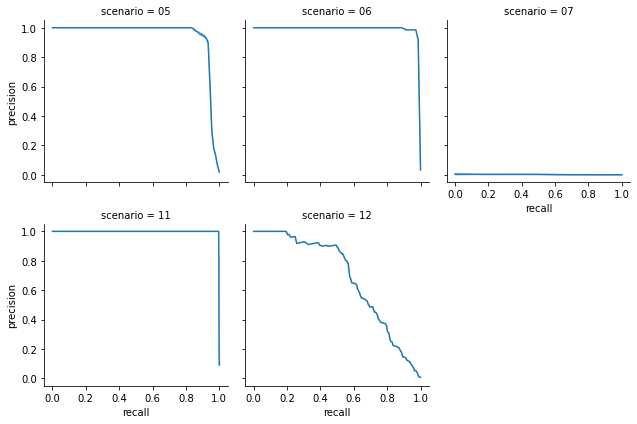

In [25]:
# precision recall graphs for each scenario
graph = sns.FacetGrid(precision_recall_all, col = 'scenario', col_wrap = 3)
graph.map(sns.lineplot, 'recall', 'precision')